In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / (1024 ** 2)    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / (1024 ** 2)
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
def binarize(df):
    for col in ('authorized_flag', 'category_1'):
        df[col] = df[col].map({'Y': 1, 'N': 0})
    return df

In [4]:
#np.iinfo?

In [5]:
def read_data(input_file_patch):
    df = pd.read_csv(input_file_patch)
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days
    return df

In [76]:
def aggregate_transactions(history):
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).astype(np.int64) * 1e-9
    print("\n after history.loc\n", history.head())
    agg_func = {
        'category_1': ['sum', 'mean'],
        'category_2_1.0': ['mean'],
        'category_2_2.0': ['mean'],
        'category_2_3.0': ['mean'],
        'category_2_4.0': ['mean'],
        'category_2_5.0': ['mean'],
        'category_3_A': ['mean'],
        'category_3_B': ['mean'],
        'category_3_C': ['mean'],
        'merchant_id': ['nunique'],
        'merchant_category_id': ['nunique'],
        'state_id': ['nunique'],
        'city_id': ['nunique'],
        'subsector_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_month': ['mean', 'max', 'min', 'std'],
        'purchase_date': [np.ptp, 'min', 'max'],
        'month_lag': ['mean', 'max', 'min', 'std'],
        'month_diff': ['mean']
    }
    agg_history = history.groupby(['card_id']).agg(agg_func)
    print("\n 1 agg_history:\n", agg_history.head())
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    print("\n 2 agg_history:\n", agg_history.head())
    agg_history.reset_index(inplace=True)
    print("\n 3 agg_history:\n", agg_history.head())
    df = (history.groupby('card_id').size().reset_index(name='transactions_count'))
    print("\n 4 df:\n", agg_history.head())
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    print("\n 5 agg_history:\n", agg_history.head())
    return agg_history

In [96]:
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])
    
    agg_func = {
        'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
        'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
    }
    
    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)
    
    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group

In [104]:
def successive_agregates(df, field1, field2):
    t = df.groupby(['card_id', field1])[field2].mean()
    print("\n1 t:\n", t)
    u = pd.DataFrame(t).reset_index().groupby('card_id')[field2].agg(['mean', 'min', 'max', 'std'])
    print("\n2 u:\n", u.head())
    u.columns = [field1 + '_' + field2 + '_' + col for col in  u.columns.values]
    print("\n3 u:\n", u.head())
    u.reset_index(inplace=True)
    return u

In [86]:
new_transactions_df = pd.read_csv('../input/new_merchant_transactions.csv', parse_dates=['purchase_date'])

In [7]:
historical_transactions_df = pd.read_csv('../input/historical_transactions.csv', parse_dates=['purchase_date'])

In [8]:
new_transactions_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [9]:
historical_transactions_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [87]:
new_transactions_df = binarize(new_transactions_df)

In [11]:
historical_transactions_df = binarize(historical_transactions_df)

In [19]:
print(historical_transactions_df[historical_transactions_df['authorized_flag'] == 1].shape[0])
print(historical_transactions_df[historical_transactions_df['authorized_flag'] == 0].shape[0])
print(historical_transactions_df[historical_transactions_df['category_1'] == 1].shape[0])
print(historical_transactions_df[historical_transactions_df['category_1'] == 0].shape[0])

26595452
2516909
2084029
27028332


In [116]:
train = read_data('../input/train.csv')

In [24]:
test = read_data('../input/test.csv')

In [117]:
target = train['target']
del train['target']

In [26]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time
0,2017-06-01,C_ID_92a2005557,5,2,1,245
1,2017-01-01,C_ID_3d0044924f,4,1,0,396
2,2016-08-01,C_ID_d639edf6cd,2,2,0,549
3,2017-09-01,C_ID_186d6a6901,4,3,0,153
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,92


In [27]:
historical_transactions_df['month_diff'] = (
    (datetime.datetime.today() - historical_transactions_df['purchase_date']).dt.days
) // 30
historical_transactions_df['month_diff'] += historical_transactions_df['month_lag']

In [88]:
new_transactions_df['month_diff'] = ((datetime.datetime.today() - new_transactions_df['purchase_date']).dt.days) // 30
new_transactions_df['month_diff'] += new_transactions_df['month_lag']

In [28]:
historical_transactions_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,month_diff
0,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37,11
1,1,C_ID_4e6213e9bc,88,0,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16,11
2,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37,12
3,1,C_ID_4e6213e9bc,88,0,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34,12
4,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37,12


In [30]:
historical_transactions_df = pd.get_dummies(historical_transactions_df, columns=['category_2', 'category_3'])

In [89]:
new_transactions_df = pd.get_dummies(new_transactions_df, columns=['category_2', 'category_3'])

In [32]:
historical_transactions_df.head()

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,month_diff,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C
0,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,16,37,11,1,0,0,0,0,1,0,0
1,1,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,16,16,11,1,0,0,0,0,1,0,0
2,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,16,37,12,1,0,0,0,0,1,0,0
3,1,C_ID_4e6213e9bc,88,0,0,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,16,34,12,1,0,0,0,0,1,0,0
4,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,16,37,12,1,0,0,0,0,1,0,0


In [33]:
historical_transactions_df = reduce_mem_usage(historical_transactions_df)

Mem. usage decreased to 1332.66 Mb (57.1% reduction)


In [90]:
new_transactions_df = reduce_mem_usage(new_transactions_df)

Mem. usage decreased to 86.12 Mb (58.9% reduction)


In [47]:
agg_fun = {'authorized_flag' : ('mean',)}
auth_mean = historical_transactions_df.groupby('card_id').agg(agg_fun)

In [52]:
#print(type(auth_mean))

In [53]:
#auth_mean.columns

In [54]:
#auth_mean.head()

In [50]:
auth_mean.columns = ['_'.join(col).strip() for col in auth_mean.columns.values]

In [56]:
auth_mean.head()

,authorized_flag_mean
card_id,
C_ID_00007093c1,0.765101
C_ID_0001238066,0.975610
C_ID_0001506ef0,0.939394
C_ID_0001793786,0.875000
C_ID_000183fdda,0.951389


In [57]:
auth_mean.reset_index(inplace=True)

In [58]:
auth_mean.head()

,card_id,authorized_flag_mean
0,C_ID_00007093c1,0.765101
1,C_ID_0001238066,0.975610
2,C_ID_0001506ef0,0.939394
3,C_ID_0001793786,0.875000
4,C_ID_000183fdda,0.951389


In [59]:
auth_mean.index

RangeIndex(start=0, stop=325540, step=1)

In [60]:
auth_mean.columns

Index(['card_id', 'authorized_flag_mean'], dtype='object')

In [61]:
authorized_transactions_df = historical_transactions_df[historical_transactions_df['authorized_flag'] == 1]
historical_transactions_df = historical_transactions_df[historical_transactions_df['authorized_flag'] == 0]

In [64]:
print(authorized_transactions_df.shape)
print(historical_transactions_df.shape)

(26595452, 21)
(2516909, 21)


In [66]:
historical_transactions_df['purchase_month'] = historical_transactions_df['purchase_date'].dt.month

In [ ]:
authorized_transactions_df['purchase_month'] = authorized_transactions_df['purchase_date'].dt.month

In [91]:
new_transactions_df['purchase_month'] = new_transactions_df['purchase_date'].dt.month

In [82]:
history = aggregate_transactions(historical_transactions_df)


 after history.loc
      authorized_flag          card_id  city_id  category_1  installments  \
115                0  C_ID_4e6213e9bc       88           0             0   
132                0  C_ID_4e6213e9bc       88           0             0   
148                0  C_ID_4e6213e9bc       88           0             0   
168                0  C_ID_4e6213e9bc      333           0             0   
213                0  C_ID_4e6213e9bc       88           0             0   

     merchant_category_id      merchant_id  month_lag  purchase_amount  \
115                   842  M_ID_22c9cfa265        -10        -0.730379   
132                   367  M_ID_86ec983688         -5        -0.723782   
148                   367  M_ID_86ec983688         -5        -0.723782   
168                   605  M_ID_c2ae34c2ef          0        -0.664262   
213                   560  M_ID_e6d5ae8ea6         -7        -0.738132   

     purchase_date  state_id  subsector_id  month_diff  category_2_1.0  \
115


 4 df:
            card_id  category_1_sum  category_1_mean  category_2_1.0_mean  \
0  C_ID_00007093c1             4.0         0.114286             0.000000   
1  C_ID_0001238066             0.0         0.000000             0.333333   
2  C_ID_0001506ef0             0.0         0.000000             0.000000   
3  C_ID_0001793786             2.0         0.074074             0.111111   
4  C_ID_000183fdda             0.0         0.000000             0.000000   

   category_2_2.0_mean  category_2_3.0_mean  category_2_4.0_mean  \
0             0.000000             0.885714                  0.0   
1             0.000000             0.000000                  0.0   
2             0.000000             1.000000                  0.0   
3             0.296296             0.111111                  0.0   
4             0.000000             1.000000                  0.0   

   category_2_5.0_mean  category_3_A_mean  category_3_B_mean  \
0             0.000000           0.000000           0.828571 

In [78]:
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]

In [79]:
history.head()

,card_id,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,hist_category_2_4.0_mean,hist_category_2_5.0_mean,hist_category_3_A_mean,hist_category_3_B_mean,hist_category_3_C_mean,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_city_id_nunique,hist_subsector_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_month_lag_mean,hist_month_lag_max,hist_month_lag_min,hist_month_lag_std,hist_month_diff_mean
0,C_ID_00007093c1,35,4.0,0.114286,0.000000,0.000000,0.885714,0.0,0.000000,0.000000,0.828571,0.171429,11,8,2,3,7,-14.401965,-0.411485,1.507069,-0.728876,0.430059,45,1.285714,3,1,0.667367,5.914286,12,1,3.071419,0.0,0.0,0.0,-6.028571,0,-11,3.535415,11.514286
1,C_ID_0001238066,3,0.0,0.000000,0.333333,0.000000,0.000000,0.0,0.666667,0.000000,1.000000,0.000000,2,1,2,2,1,-1.789928,-0.596643,-0.596643,-0.596643,0.000000,3,1.000000,1,1,0.000000,8.666667,12,2,5.773503,0.0,0.0,0.0,-1.333333,0,-2,1.154701,11.000000
2,C_ID_0001506ef0,4,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.750000,0.250000,0.000000,4,4,1,1,4,-2.905782,-0.726445,-0.708590,-0.740491,0.016203,1,0.250000,1,0,0.500000,5.500000,12,2,4.725816,0.0,0.0,0.0,-2.500000,0,-8,3.785939,11.500000
3,C_ID_0001793786,27,2.0,0.074074,0.111111,0.296296,0.111111,0.0,0.000000,0.814815,0.185185,0.000000,17,14,4,8,11,-11.825338,-0.437975,1.236592,-0.745405,0.498150,5,0.185185,1,0,0.395847,6.481481,9,3,2.375684,0.0,0.0,0.0,-3.518519,-1,-7,2.375684,15.444444
4,C_ID_000183fdda,7,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.428571,0.571429,4,4,1,1,4,-0.941381,-0.134483,0.334099,-0.714541,0.452741,19,2.714286,6,1,2.288689,8.285714,10,8,0.755929,0.0,0.0,0.0,-5.714286,-4,-6,0.755929,11.285714


In [80]:
authorized = aggregate_transactions(authorized_transactions_df)


 after history.loc
    authorized_flag          card_id  city_id  category_1  installments  \
0                1  C_ID_4e6213e9bc       88           0             0   
1                1  C_ID_4e6213e9bc       88           0             0   
2                1  C_ID_4e6213e9bc       88           0             0   
3                1  C_ID_4e6213e9bc       88           0             0   
4                1  C_ID_4e6213e9bc       88           0             0   

   merchant_category_id      merchant_id  month_lag  purchase_amount  \
0                    80  M_ID_e020e9b302         -8        -0.703331   
1                   367  M_ID_86ec983688         -7        -0.733128   
2                    80  M_ID_979ed661fc         -6        -0.720386   
3                   560  M_ID_e6d5ae8ea6         -5        -0.735352   
4                    80  M_ID_e020e9b302        -11        -0.722865   

   purchase_date  state_id  subsector_id  month_diff  category_2_1.0  \
0   1.498405e+09        16   


 4 df:
            card_id  category_1_sum  category_1_mean  category_2_1.0_mean  \
0  C_ID_00007093c1            24.0         0.210526             0.000000   
1  C_ID_0001238066             2.0         0.016667             0.783333   
2  C_ID_0001506ef0             0.0         0.000000             0.032258   
3  C_ID_0001793786             0.0         0.000000             0.042328   
4  C_ID_000183fdda             4.0         0.029197             0.051095   

   category_2_2.0_mean  category_2_3.0_mean  category_2_4.0_mean  \
0             0.000000             0.780702                  0.0   
1             0.000000             0.000000                  0.0   
2             0.000000             0.967742                  0.0   
3             0.359788             0.063492                  0.0   
4             0.007299             0.905109                  0.0   

   category_2_5.0_mean  category_3_A_mean  category_3_B_mean  \
0             0.008772                0.0           0.842105 

In [83]:
authorized.columns = ['auth_' + c if c != 'card_id' else c for c in authorized.columns]

In [84]:
authorized.head()

,card_id,auth_transactions_count,auth_category_1_sum,auth_category_1_mean,auth_category_2_1.0_mean,auth_category_2_2.0_mean,auth_category_2_3.0_mean,auth_category_2_4.0_mean,auth_category_2_5.0_mean,auth_category_3_A_mean,auth_category_3_B_mean,auth_category_3_C_mean,auth_merchant_id_nunique,auth_merchant_category_id_nunique,auth_state_id_nunique,auth_city_id_nunique,auth_subsector_id_nunique,auth_purchase_amount_sum,auth_purchase_amount_mean,auth_purchase_amount_max,auth_purchase_amount_min,auth_purchase_amount_std,auth_installments_sum,auth_installments_mean,auth_installments_max,auth_installments_min,auth_installments_std,auth_purchase_month_mean,auth_purchase_month_max,auth_purchase_month_min,auth_purchase_month_std,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_month_lag_mean,auth_month_lag_max,auth_month_lag_min,auth_month_lag_std,auth_month_diff_mean
0,C_ID_00007093c1,114,24.0,0.210526,0.000000,0.000000,0.780702,0.0,0.008772,0.0,0.842105,0.157895,28,18,3,4,13,-62.443077,-0.547746,1.206539,-0.728876,0.237426,147,1.289474,6,1,0.795159,6.517544,12,1,3.371490,32627654.0,1.487081e+09,1.519708e+09,-5.798246,0,-12,3.441495,11.596491
1,C_ID_0001238066,120,2.0,0.016667,0.783333,0.000000,0.000000,0.0,0.150000,0.0,0.708333,0.266667,65,29,6,18,17,-70.657272,-0.588811,0.768095,-0.734887,0.192614,195,1.625000,10,-1,1.501050,7.275000,12,1,4.895483,13110825.0,1.506638e+09,1.519748e+09,-1.825000,0,-5,1.294218,11.266667
2,C_ID_0001506ef0,62,0.0,0.000000,0.032258,0.000000,0.967742,0.0,0.000000,1.0,0.000000,0.000000,28,19,2,3,12,-31.696098,-0.511227,1.493545,-0.740491,0.484575,0,0.000000,0,0,0.000000,6.887097,12,1,4.538017,34460275.0,1.484411e+09,1.518871e+09,-4.983871,0,-13,4.248402,11.645161
3,C_ID_0001793786,189,0.0,0.000000,0.042328,0.359788,0.063492,0.0,0.000000,1.0,0.000000,0.000000,114,45,4,9,22,-24.960674,-0.132067,4.554145,-0.737892,0.867916,0,0.000000,0,0,0.000000,6.698413,10,1,2.301491,24487497.0,1.484994e+09,1.509481e+09,-3.301587,0,-9,2.301491,15.349206
4,C_ID_000183fdda,137,4.0,0.029197,0.051095,0.007299,0.905109,0.0,0.007299,0.0,0.729927,0.240876,71,34,7,9,20,-67.896553,-0.495595,2.764788,-0.737892,0.523760,245,1.788321,10,-1,2.108912,6.810219,12,1,4.538289,15148616.0,1.504444e+09,1.519592e+09,-2.284672,0,-5,1.782055,11.445255


In [92]:
new = aggregate_transactions(new_transactions_df)


 after history.loc
    authorized_flag          card_id  city_id  category_1  installments  \
0                1  C_ID_415bb3a509      107           0             1   
1                1  C_ID_415bb3a509      140           0             1   
2                1  C_ID_415bb3a509      330           0             1   
3                1  C_ID_415bb3a509       -1           1             1   
4                1  C_ID_ef55cf8d4b       -1           1             1   

   merchant_category_id      merchant_id  month_lag  purchase_amount  \
0                   307  M_ID_b0c793002c          1        -0.557617   
1                   307  M_ID_88920c89e8          1        -0.569336   
2                   507  M_ID_ad5237ef6b          2        -0.551270   
3                   661  M_ID_9e84cda3b1          1        -0.671875   
4                   166  M_ID_3c86fa3831          1        -0.659668   

   purchase_date  state_id  subsector_id  month_diff  category_2_1.0  \
0   1.520780e+09         9   


 4 df:
            card_id  category_1_sum  category_1_mean  category_2_1.0_mean  \
0  C_ID_00007093c1               0         0.000000             0.500000   
1  C_ID_0001238066               2         0.076923             0.769231   
2  C_ID_0001506ef0               0         0.000000             0.000000   
3  C_ID_0001793786               0         0.000000             0.483871   
4  C_ID_000183fdda               0         0.000000             0.000000   

   category_2_2.0_mean  category_2_3.0_mean  category_2_4.0_mean  \
0             0.000000              0.50000                  0.0   
1             0.000000              0.00000                  0.0   
2             0.000000              1.00000                  0.0   
3             0.258065              0.16129                  0.0   
4             0.000000              1.00000                  0.0   

   category_2_5.0_mean  category_3_A_mean  category_3_B_mean  \
0             0.000000                0.0           1.000000 

In [93]:
new.columns = ['new_' + c if c != 'card_id' else c for c in new.columns]

In [94]:
new.head()

,card_id,new_transactions_count,new_category_1_sum,new_category_1_mean,new_category_2_1.0_mean,new_category_2_2.0_mean,new_category_2_3.0_mean,new_category_2_4.0_mean,new_category_2_5.0_mean,new_category_3_A_mean,new_category_3_B_mean,new_category_3_C_mean,new_merchant_id_nunique,new_merchant_category_id_nunique,new_state_id_nunique,new_city_id_nunique,new_subsector_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_std,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_month_lag_mean,new_month_lag_max,new_month_lag_min,new_month_lag_std,new_month_diff_mean
0,C_ID_00007093c1,2,0,0.000000,0.500000,0.000000,0.50000,0.0,0.000000,0.0,1.000000,0.000000,2,2,2,2,2,-1.328125,-0.664062,-0.656738,-0.671875,0.010704,2,1.000000,1,1,0.000000,4.000000,4,4,0.000000,537024.0,1.522754e+09,1.523291e+09,2.000000,2,2,0.000000,12.000000
1,C_ID_0001238066,26,2,0.076923,0.769231,0.000000,0.00000,0.0,0.115385,0.0,0.807692,0.153846,25,15,4,8,9,-14.851562,-0.571289,-0.078308,-0.740723,0.173462,42,1.615385,10,-1,2.079941,3.346154,4,3,0.485165,5195343.0,1.519923e+09,1.525118e+09,1.346154,2,1,0.485165,11.192308
2,C_ID_0001506ef0,2,0,0.000000,0.000000,0.000000,1.00000,0.0,0.000000,1.0,0.000000,0.000000,1,2,1,1,2,-1.447266,-0.723633,-0.715332,-0.731934,0.011742,0,0.000000,0,0,0.000000,3.000000,3,3,0.000000,471152.0,1.521239e+09,1.521710e+09,1.000000,1,1,0.000000,11.000000
3,C_ID_0001793786,31,0,0.000000,0.483871,0.258065,0.16129,0.0,0.032258,1.0,0.000000,0.000000,31,21,5,7,14,-0.229004,-0.007385,3.130859,-0.737793,0.947266,0,0.000000,0,0,0.000000,11.322581,12,11,0.475191,3981096.0,1.510761e+09,1.514742e+09,1.322581,2,1,0.475191,15.032258
4,C_ID_000183fdda,11,0,0.000000,0.000000,0.000000,1.00000,0.0,0.000000,0.0,0.545455,0.363636,11,9,2,2,6,-6.589844,-0.599121,-0.107666,-0.732422,0.182861,16,1.454545,4,-1,1.293340,3.272727,4,3,0.467099,5106807.0,1.519994e+09,1.525100e+09,1.272727,2,1,0.467099,11.727273


In [97]:
final_group = aggregate_per_month(authorized_transactions_df)

In [98]:
final_group.head(10)

,card_id,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std,installments_count_mean,installments_count_std,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std
0,C_ID_00007093c1,-6.000000,3.894440,8.769231,3.539158,-4.803313,2.175011,-0.536131,0.075418,-0.702649,0.041293,-0.126683,0.446167,0.197339,0.120199,8.769231,3.539158,11.307692,4.210792,1.369646,0.423190,1.000000,0.000000,2.538462,1.613246,0.625428,0.675607
1,C_ID_0001238066,-2.500000,1.870829,20.000000,11.696153,-11.776212,6.676914,-0.603215,0.046045,-0.730351,0.002699,-0.160977,0.485869,0.151393,0.093832,20.000000,11.696153,32.500000,24.501020,1.652873,0.410539,0.666667,0.816497,4.666667,2.875181,1.256525,0.521292
2,C_ID_0001506ef0,-6.230769,4.225988,4.769231,4.342692,-2.438161,2.902502,-0.446660,0.271125,-0.725724,0.011212,0.161333,0.748701,0.496308,0.415117,4.769231,4.342692,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,C_ID_0001793786,-4.500000,3.027650,18.900000,12.160501,-2.496067,4.018810,-0.005687,0.271221,-0.646277,0.166230,2.190924,1.290775,0.880276,0.259048,18.900000,12.160501,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,C_ID_000183fdda,-2.500000,1.870829,22.833333,7.167054,-11.316092,4.800612,-0.489227,0.141015,-0.728405,0.009876,1.151797,1.062785,0.472149,0.315407,22.833333,7.167054,40.833333,14.048725,1.834943,0.362557,0.333333,1.032796,9.166667,2.041241,2.144389,0.665529
5,C_ID_00024e244b,-6.384615,4.330867,4.076923,4.290717,-2.557395,2.089708,-0.685118,0.071894,-0.728885,0.016051,-0.425292,0.813979,0.108521,0.208719,4.076923,4.290717,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,C_ID_0002709b5a,-5.000000,3.316625,6.090909,3.505839,-3.994622,2.440540,-0.638637,0.060836,-0.700104,0.030670,-0.546063,0.092512,0.076295,0.051724,6.090909,3.505839,10.727273,8.427229,1.965729,1.287108,0.818182,0.603023,3.818182,3.341203,1.600058,1.734256
7,C_ID_00027503e2,-4.000000,2.738613,2.666667,1.224745,-1.974976,0.909525,-0.740077,0.002424,-0.742206,0.003025,-0.737762,0.002652,0.003165,0.001086,2.666667,1.224745,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,C_ID_000298032a,-5.250000,4.334249,3.500000,1.772811,-1.844563,0.699127,-0.590214,0.168008,-0.686623,0.020383,-0.210304,1.127668,0.213951,0.442601,3.500000,1.772811,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,C_ID_0002ba3c2e,-4.666667,3.141125,9.166667,4.665476,-5.843051,3.021165,-0.638037,0.044976,-0.721448,0.026047,-0.387276,0.222295,0.107390,0.060790,9.166667,4.665476,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [105]:
additional_fields = successive_agregates(new_transactions_df, 'category_1', 'purchase_amount')


1 t:
 card_id          category_1
C_ID_00007093c1  0            -0.664062
C_ID_0001238066  0            -0.564453
                 1            -0.650391
C_ID_0001506ef0  0            -0.723633
C_ID_0001793786  0            -0.007385
C_ID_000183fdda  0            -0.599121
C_ID_0002709b5a  0            -0.672852
C_ID_000298032a  0            -0.642090
C_ID_0002ba3c2e  0            -0.690430
C_ID_0002c7c2c1  0            -0.654785
C_ID_00032df08f  0            -0.348877
C_ID_0003754056  0            -0.709473
C_ID_000377f6a0  0            -0.613281
C_ID_0003be3c83  0            -0.573730
C_ID_0003f41435  0            -0.732910
C_ID_00042d509c  0            -0.720703
                 1            -0.467285
C_ID_0004587331  0            -0.734375
C_ID_0004725b87  0            -0.619141
C_ID_0004888ddd  0            -0.693359
C_ID_0004b68c49  0            -0.597168
                 1            -0.625977
C_ID_0004c2a5ab  0            -0.643555
                 1            -0.535645
C_ID_

In [106]:
additional_fields = additional_fields.merge(
    successive_agregates(new_transactions_df, 'installments', 'purchase_amount'),
    on='card_id',
    how='left'
)


1 t:
 card_id          installments
C_ID_00007093c1   1             -0.664062
C_ID_0001238066  -1             -0.151978
                  1             -0.625977
                  3             -0.215088
                  6             -0.559570
                  10            -0.566895
C_ID_0001506ef0   0             -0.723633
C_ID_0001793786   0             -0.007385
C_ID_000183fdda  -1             -0.107666
                  1             -0.696289
                  2             -0.653320
                  3             -0.539062
                  4             -0.459717
C_ID_0002709b5a  -1             -0.611816
                  1             -0.703613
C_ID_000298032a   0             -0.642090
C_ID_0002ba3c2e   0             -0.690430
C_ID_0002c7c2c1   0             -0.654785
C_ID_00032df08f   1             -0.348877
C_ID_0003754056   0             -0.709473
C_ID_000377f6a0   0             -0.613281
C_ID_0003be3c83   1             -0.716309
                  3             -0.4079

In [107]:
additional_fields = additional_fields.merge(
    successive_agregates(new_transactions_df, 'city_id', 'purchase_amount'),
    on='card_id',
    how='left'
)


1 t:
 card_id          city_id
C_ID_00007093c1   69       -0.656738
                  76       -0.671875
C_ID_0001238066  -1        -0.666992
                  69       -0.516602
                  169      -0.500488
                  248      -0.596680
                  288      -0.487061
                  291      -0.605469
                  314      -0.620605
                  333      -0.472168
C_ID_0001506ef0   137      -0.723633
C_ID_0001793786   69        0.234863
                  87        0.249268
                  96       -0.504395
                  143      -0.361572
                  179      -0.572754
                  204      -0.291504
                  322      -0.483154
C_ID_000183fdda   25       -0.539062
                  161      -0.604980
C_ID_0002709b5a   69       -0.680664
                  103      -0.726562
                  160      -0.611816
C_ID_000298032a   23       -0.642090
C_ID_0002ba3c2e   344      -0.690430
C_ID_0002c7c2c1   69       -0.671387
      

In [109]:
additional_fields = additional_fields.merge(
    successive_agregates(new_transactions_df, 'category_1', 'installments'),
    on='card_id',
    how='left'
)


1 t:
 card_id          category_1
C_ID_00007093c1  0              1.000000
C_ID_0001238066  0              1.458333
                 1              3.500000
C_ID_0001506ef0  0              0.000000
C_ID_0001793786  0              0.000000
C_ID_000183fdda  0              1.454545
C_ID_0002709b5a  0              0.333333
C_ID_000298032a  0              0.000000
C_ID_0002ba3c2e  0              0.000000
C_ID_0002c7c2c1  0              0.000000
C_ID_00032df08f  0              1.000000
C_ID_0003754056  0              0.000000
C_ID_000377f6a0  0              0.000000
C_ID_0003be3c83  0              2.833333
C_ID_0003f41435  0              0.000000
C_ID_00042d509c  0              1.000000
                 1              3.000000
C_ID_0004587331  0              0.000000
C_ID_0004725b87  0              2.000000
C_ID_0004888ddd  0              0.000000
C_ID_0004b68c49  0              1.000000
                 1              1.000000
C_ID_0004c2a5ab  0              1.000000
                 1    

In [118]:
train = pd.merge(train, history, on='card_id', how='left')

In [112]:
test = pd.merge(test, history, on='card_id', how='left')

In [119]:
train = pd.merge(train, authorized, on='card_id', how='left')

In [114]:
test = pd.merge(test, authorized, on='card_id', how='left')

In [120]:
train = pd.merge(train, new, on='card_id', how='left')

In [121]:
test = pd.merge(test, new, on='card_id', how='left')

In [122]:
train = pd.merge(train, final_group, on='card_id', how='left')

In [123]:
test = pd.merge(test, final_group, on='card_id', how='left')

In [124]:
train = pd.merge(train, auth_mean, on='card_id', how='left')

In [125]:
test = pd.merge(test, auth_mean, on='card_id', how='left')

In [126]:
train = pd.merge(train, additional_fields, on='card_id', how='left')

In [127]:
test = pd.merge(test, additional_fields, on='card_id', how='left')

In [128]:
test.to_csv('test.csv')

In [129]:
train['target'] = target
train.to_csv('train.csv')
del train['target']

In [130]:
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
#features = [f for f in features if f not in unimportant_features]
categorical_feats = ['feature_2', 'feature_3']

In [131]:
param = {
    'num_leaves': 111,
    'min_data_in_leaf': 149,
    'objective':'regression',
    'max_depth': 9,
    'learning_rate': 0.005,
    'boosting': 'gbdt',
    'feature_fraction': 0.7522,
    'bagging_freq': 1,
    'bagging_fraction': 0.7083 ,
    'bagging_seed': 11,
    'metric': 'rmse',
    'lambda_l1': 0.2634,
    'random_state': 133,
    'verbosity': -1
}

In [134]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(
        train.iloc[trn_idx][features],
        label=target.iloc[trn_idx],
        categorical_feature=categorical_feats
    )
    val_data = lgb.Dataset(
        train.iloc[val_idx][features],
        label=target.iloc[val_idx],
        categorical_feature=categorical_feats
    
    )
    
    num_round = 10000
    
    clf = lgb.train(
        param,
        trn_data,
        num_round,
        valid_sets= [trn_data, val_data],
        verbose_eval=100,
        early_stopping_rounds=200
    )
    
    oof[val_idx] = clf.predict(
        train.iloc[val_idx][features],
        num_iteration=clf.best_iteration
    )
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df['feature'] = features
    fold_importance_df['importance'] = clf.feature_importance()
    fold_importance_df['fold'] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits
    
print("CV score: {:<8.5f}".format(mean_squared_error(oof, target) ** 0.5))

fold n°0


/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/lightgbm/basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.71403	valid_1's rmse: 3.77586
[200]	training's rmse: 3.64455	valid_1's rmse: 3.72769
[300]	training's rmse: 3.60169	valid_1's rmse: 3.70476
[400]	training's rmse: 3.57076	valid_1's rmse: 3.69257
[500]	training's rmse: 3.54744	valid_1's rmse: 3.68532
[600]	training's rmse: 3.52834	valid_1's rmse: 3.68068
[700]	training's rmse: 3.51205	valid_1's rmse: 3.67778
[800]	training's rmse: 3.49769	valid_1's rmse: 3.67576
[900]	training's rmse: 3.48411	valid_1's rmse: 3.67446
[1000]	training's rmse: 3.47199	valid_1's rmse: 3.6733
[1100]	training's rmse: 3.46068	valid_1's rmse: 3.67275
[1200]	training's rmse: 3.44926	valid_1's rmse: 3.67234
[1300]	training's rmse: 3.43882	valid_1's rmse: 3.67232
[1400]	training's rmse: 3.42867	valid_1's rmse: 3.67225
[1500]	training's rmse: 3.41826	valid_1's rmse: 3.67187
[1600]	training's rmse: 3.40846	valid_1's rmse: 3.67201
[1700]	training's rmse: 3.39829	valid_1's rmse: 3.6

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/lightgbm/basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.73094	valid_1's rmse: 3.70449
[200]	training's rmse: 3.66047	valid_1's rmse: 3.65945
[300]	training's rmse: 3.61668	valid_1's rmse: 3.63828
[400]	training's rmse: 3.58541	valid_1's rmse: 3.62804
[500]	training's rmse: 3.56149	valid_1's rmse: 3.62259
[600]	training's rmse: 3.54207	valid_1's rmse: 3.61931
[700]	training's rmse: 3.52584	valid_1's rmse: 3.61738
[800]	training's rmse: 3.51147	valid_1's rmse: 3.61615
[900]	training's rmse: 3.49742	valid_1's rmse: 3.61488
[1000]	training's rmse: 3.48471	valid_1's rmse: 3.614
[1100]	training's rmse: 3.47339	valid_1's rmse: 3.61315
[1200]	training's rmse: 3.4618	valid_1's rmse: 3.61273
[1300]	training's rmse: 3.45063	valid_1's rmse: 3.61249
[1400]	training's rmse: 3.44083	valid_1's rmse: 3.61234
[1500]	training's rmse: 3.43106	valid_1's rmse: 3.61209
[1600]	training's rmse: 3.42081	valid_1's rmse: 3.61194
[1700]	training's rmse: 3.41153	valid_1's rmse: 3.611

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/lightgbm/basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.7347	valid_1's rmse: 3.68029
[200]	training's rmse: 3.6635	valid_1's rmse: 3.63843
[300]	training's rmse: 3.61911	valid_1's rmse: 3.6199
[400]	training's rmse: 3.58724	valid_1's rmse: 3.61002
[500]	training's rmse: 3.56285	valid_1's rmse: 3.60425
[600]	training's rmse: 3.54309	valid_1's rmse: 3.60144
[700]	training's rmse: 3.52639	valid_1's rmse: 3.59979
[800]	training's rmse: 3.51178	valid_1's rmse: 3.59815
[900]	training's rmse: 3.49896	valid_1's rmse: 3.59742
[1000]	training's rmse: 3.48619	valid_1's rmse: 3.59698
[1100]	training's rmse: 3.47387	valid_1's rmse: 3.59681
[1200]	training's rmse: 3.46233	valid_1's rmse: 3.5965
[1300]	training's rmse: 3.45178	valid_1's rmse: 3.59676
Early stopping, best iteration is:
[1189]	training's rmse: 3.46364	valid_1's rmse: 3.59642
fold n°3


/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/lightgbm/basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.68651	valid_1's rmse: 3.87884
[200]	training's rmse: 3.61743	valid_1's rmse: 3.83172
[300]	training's rmse: 3.57361	valid_1's rmse: 3.80879
[400]	training's rmse: 3.54206	valid_1's rmse: 3.79724
[500]	training's rmse: 3.51787	valid_1's rmse: 3.79117
[600]	training's rmse: 3.49844	valid_1's rmse: 3.78712
[700]	training's rmse: 3.48136	valid_1's rmse: 3.78446
[800]	training's rmse: 3.46659	valid_1's rmse: 3.78283
[900]	training's rmse: 3.45325	valid_1's rmse: 3.78238
[1000]	training's rmse: 3.44088	valid_1's rmse: 3.78174
[1100]	training's rmse: 3.42877	valid_1's rmse: 3.78145
[1200]	training's rmse: 3.41729	valid_1's rmse: 3.78112
[1300]	training's rmse: 3.40583	valid_1's rmse: 3.78063
[1400]	training's rmse: 3.39525	valid_1's rmse: 3.78076
Early stopping, best iteration is:
[1293]	training's rmse: 3.40674	valid_1's rmse: 3.78059
fold n°4


/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/lightgbm/basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.73154	valid_1's rmse: 3.69343
[200]	training's rmse: 3.66067	valid_1's rmse: 3.65231
[300]	training's rmse: 3.61648	valid_1's rmse: 3.63408
[400]	training's rmse: 3.58547	valid_1's rmse: 3.62495
[500]	training's rmse: 3.56216	valid_1's rmse: 3.61952
[600]	training's rmse: 3.54306	valid_1's rmse: 3.61696
[700]	training's rmse: 3.52668	valid_1's rmse: 3.61521
[800]	training's rmse: 3.51216	valid_1's rmse: 3.61428
[900]	training's rmse: 3.49867	valid_1's rmse: 3.61389
[1000]	training's rmse: 3.48652	valid_1's rmse: 3.61341
[1100]	training's rmse: 3.47422	valid_1's rmse: 3.61297
[1200]	training's rmse: 3.463	valid_1's rmse: 3.6129
[1300]	training's rmse: 3.4519	valid_1's rmse: 3.61278
[1400]	training's rmse: 3.4408	valid_1's rmse: 3.61301
Early stopping, best iteration is:
[1284]	training's rmse: 3.45395	valid_1's rmse: 3.61272
CV score: 3.65531 


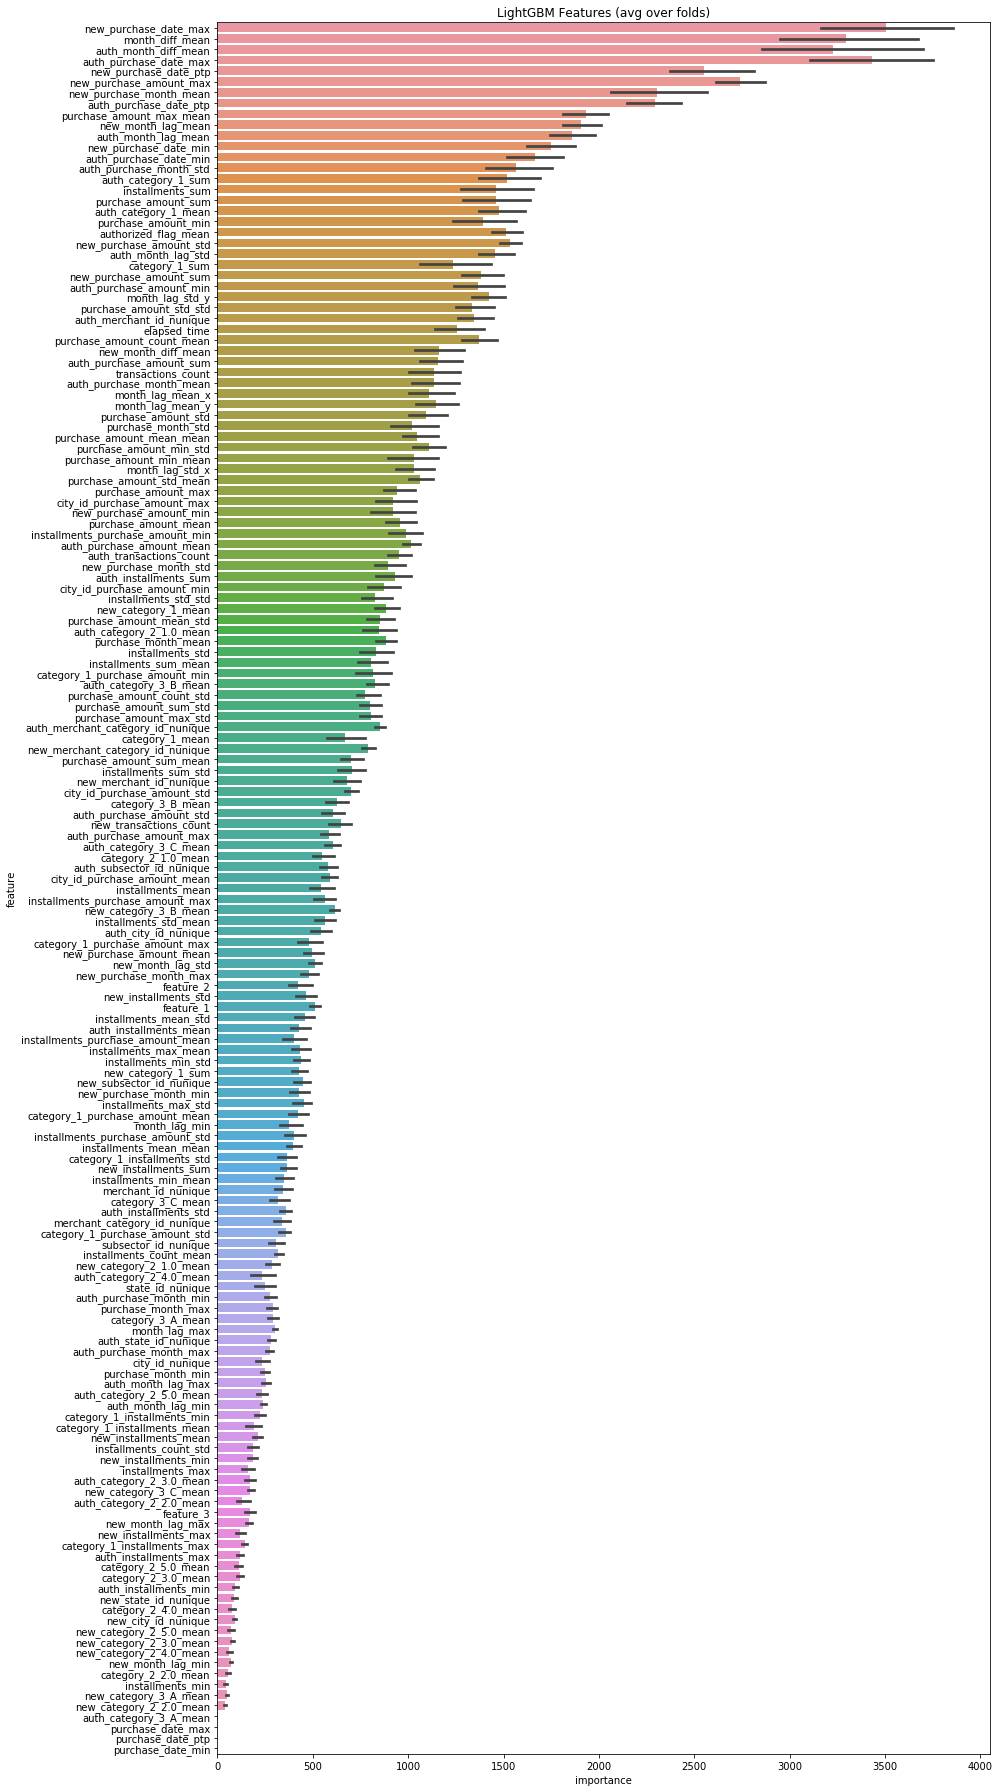

In [135]:
cols = (
    feature_importance_df[['feature', 'importance']]
    .groupby('feature')
    .mean()
    .sort_values(by='importance', ascending=False)[:1000].index
)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14, 25))
sns.barplot(
    x="importance",
    y="feature",
    data=best_features.sort_values(by='importance', ascending=False)
)
plt.title("LightGBM Features (avg over folds)")
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [136]:
submission_df = pd.DataFrame({'card_id': test['card_id'].values})
submission_df['target'] = predictions
submission_df.to_csv('submit.csv', index=False)